In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

#Variables globales
CUSTOM_FORMAT = {"with_labels" : False,
                "node_size": 20, "node_color": "#ff0000", "edgecolors": "#911a07",
                "width": 0.4, "edge_color": "black"}

In [2]:
def calcular_grado_vector(A: np.ndarray):
    '''The vector k whose elements are the degrees ki of all nodes
    i = 1, 2,..., N.'''
    return A.dot(np.ones(A.shape[0]))

def calcular_num_aristas(A: np.ndarray):
    '''The total number of links, L, in the network.'''
    k = calcular_grado_vector(A)
    return k.dot(np.ones_like(k))/2

def calcular_num_triangulos(A: np.ndarray):
    '''The number of triangles T present in the network,
    where a triangle means three nodes, each connected by links to
    the other two'''
    return (A@A@A).trace()/6

def calcular_knn_vector(A: np.ndarray):
    '''The vector knn whose element i is the sum of the degrees of
    node i's neighbors.'''
    return (A@A).dot(np.ones(A.shape[0]))

def calcular_knnn_vector(A: np.ndarray):
    '''The vector knnn whose element i is the sum of the degrees of
    node i's second neighbors.'''
    return (A@A@A).dot(np.ones(A.shape[0]))

In [23]:
filename = f'datasets/Y2H.txt'
df_y2h = pd.read_csv(filename, delimiter="\t", header=None, names=["source", "target"])
net_y2h = nx.from_pandas_edgelist(df_y2h, create_using=nx.Graph)
df_y2h

,source,target
0,MEL1,YJL092W
1,Q0085,YCR106W
2,TORF1,YCR106W
3,TORF19,YDR361C
4,TORF21,YKR048C
...,...,...
2925,YPR071W,YPR071W
2926,YPR105C,YPR191W
2927,YPR118W,YPR118W
2928,YPR158WA,YPR158WA


In [73]:
networks = ['AP-MS', 'LIT', 'Y2H']
files = [f'{name}.txt' for name in networks]
dataframes = [pd.read_csv(f'datasets/{filename}', delimiter="\t",
                          header=None, names=["source", "target"]) for filename in files]
graphs = [nx.from_pandas_edgelist(df, create_using=nx.Graph) for df in dataframes]

attrs = {}

for net, graph in zip(networks, graphs):
    attr = {}
    attr['node_number'] = len(graph.nodes)
    attr['edge_number'] = len(graph.edges)
    attr['directed'] = False  # REVISAR
    degrees = list(dict(graph.degree).values())
    attr['k_mean'] = np.mean(degrees)
    attr['k_min'] = np.min(degrees)
    attr['k_max'] = np.max(degrees)
    attr['density'] = 2*attr['edge_number']/(attr['node_number']*(attr['node_number']-1))
    attr['g_mean'] = nx.average_clustering(graph, count_zeros=True)
    attr['transitivity'] = nx.transitivity(graph)
    components = nx.connected_components(graph)
    diams = [nx.diameter(graph.subgraph(comp).copy()) for comp in components]
    attr['diameter'] = max(diams)
    attrs[net] = attr
    


In [80]:
pd.DataFrame(attrs).rename(index = {"node_number": "Numero de nodos",
                                    "edge_number": "Numero de enlaces",
                                    "directed": "Es dirigida?",
                                    "k_mean": "Grado medio",
                                    "k_max": "Grado máximo",
                                    "k_min": "Grado mínimo",
                                    "density": "Densidad",
                                    "g_mean": "Coeficiente de Clustering medio",
                                    "transitivity": "Coeficiente de Clustering global",
                                    "diameter": "Diámetro"}).T

,Numero de nodos,Numero de enlaces,Es dirigida?,Grado medio,Grado mínimo,Grado máximo,Densidad,Coeficiente de Clustering medio,Coeficiente de Clustering global,Diámetro
AP-MS,1622,9070,False,11.183724,1,127,0.006899,0.554636,0.61859,15
LIT,1536,2925,False,3.808594,1,40,0.002481,0.292492,0.346193,19
Y2H,2018,2930,False,2.903865,1,91,0.00144,0.046194,0.023614,14


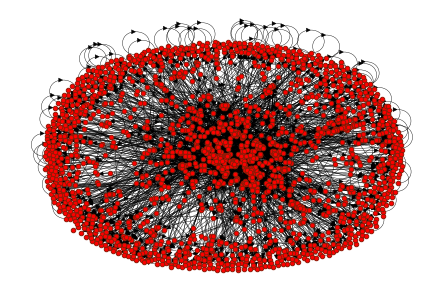

In [10]:
nx.draw(graph, **CUSTOM_FORMAT)

In [21]:
class DataSet:
    """
    Contenedor de los datos a utilizar. Implementa métodos para obtener visualizaciones y datos
    de la red asociada a los datos.
    """
    
    def __init__(self, filename: str, drop_self_edges: bool = False):
        colnames = ["source", "target"]
        
        #Import del .txt
        self.df = pd.read_csv(filename, delimiter = "\t", header = None, names = colnames)
        #Encoding y removemos los auto-nodos
        self.df_mod = self.encode(self.drop_self_nodes(self.df)) if drop_self_edges else self.encode(self.df)
        #Creamos la red
        self.Red = nx.from_pandas_edgelist(self.df_mod) 
        #Guardamos la matriz de adyacencia
        self.M_df = nx.to_pandas_adjacency(self.Red)
        self.M = np.array(self.M_df)

    @staticmethod
    def encode(df: pd.DataFrame) -> pd.DataFrame:
        """Label encoding de la data categórica"""
        node_names = list(df["source"].unique()) + list(df["target"].unique())
        encode = {k: v for v, k in enumerate(node_names)}
        return  df[["source", "target"]].replace(encode)

    @staticmethod
    def drop_self_nodes(df: pd.DataFrame) -> pd.DataFrame:
        """Drop de los enlaces consigo mismo"""
        non_repeated = [i for i in df.index if df.loc[i, "source"] != df.loc[i, "target"]]
        return df.loc[non_repeated]

    def draw_net(self):
        """Plot de la red"""
        global CUSTOM_FORMAT
        
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(111)
        nx.draw(self.Red, **CUSTOM_FORMAT)
        return fig, ax

    def get_stats(self):
        """Consigue los datos importantes de la red"""
        
        cant_trig = (self.M@self.M@self.M).trace()/6
        print("Cantidad de triangulos: {}".format(cant_trig))
        
        """
                                    WARNING
        Falta implementar toda la lista de parámetros que hay en el TP.
        Estaría bueno mirar como hacerlo con la matriz de adyacencia, pero comparar
        con los métodos de networkx. Ingresar a los métodos de networkx con
        object.Red.method()
        """
        
        return dict(cantidad_triangulos = cant_trig, )

#Clases especiales para los tres datasets que tenemos por si 
#queremos tocar a mano algo especial de los gráficos.
class Y2H(DataSet):
    def __init__(self, drop_self_edges = False):
        super().__init__("https://raw.githubusercontent.com/facundojgarcia02/CoNet/main/datasets/TP1/Y2H.txt", drop_self_edges = drop_self_edges)
        
class APMS(DataSet):
    def __init__(self, drop_self_edges = False):
        super().__init__("https://raw.githubusercontent.com/facundojgarcia02/CoNet/main/datasets/TP1/AP-MS.txt", drop_self_edges = drop_self_edges)
        
class LIT(DataSet):
    def __init__(self, drop_self_edges = False):
        super().__init__("https://raw.githubusercontent.com/facundojgarcia02/CoNet/main/datasets/TP1/LIT.txt", drop_self_edges = drop_self_edges)

In [22]:
y2h = Y2H(drop_self_edges=True)

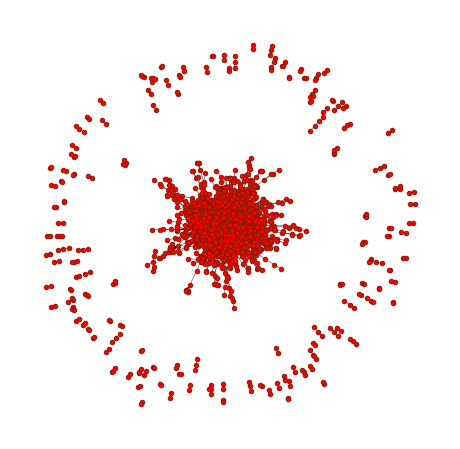

In [23]:
fig, ax = y2h.draw_net()